<a href="https://colab.research.google.com/github/pemujo/w210-capstone/blob/main/Contrails_baseline_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install gcsfs
# !pip install pandarallel

In [3]:
import pandas as pd
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display
import os 
import glob
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
import multiprocessing

from tqdm import tqdm
from collections import Counter

In [4]:
# To use all available CPUs
n_cpus = multiprocessing.cpu_count()
print('CPUs available: ', n_cpus)
pandarallel.initialize(progress_bar=True, nb_workers=n_cpus)

CPUs available:  4
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
import os
fs = None
BASE_DIR = None
train_metadata_df = []
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import auth
    auth.authenticate_user()
    import gcsfs
    fs = gcsfs.GCSFileSystem(project='multi-tenancy-dataproc')
    BASE_DIR = 'kaggle-contrails/contrails-kaggle-files/'
    train_metadata_df = pd.read_json("gs://" + BASE_DIR + "train_metadata.json")
elif "ec2" in str(os.environ.get("USER")):
    print("running in AWS")
    import boto3
    import s3fs
    s3 = boto3.resource('s3')
    fs = s3fs.S3FileSystem()
    BASE_DIR = 'w210-capstone/'
    train_metadata_df = pd.read_json("s3://" + BASE_DIR + "train_metadata.json")
else:
    print('Defaulting to environment with Google Cloud Storage')
    import gcsfs
    fs = gcsfs.GCSFileSystem(project='multi-tenancy-dataproc')
    BASE_DIR = 'kaggle-contrails/contrails-kaggle-files/'
    train_metadata_df = pd.read_json("gs://" + BASE_DIR + "train_metadata.json")
    
TRAIN_DIR = BASE_DIR + "train/"
VALIDATION_DIR = BASE_DIR + "validation/"

Defaulting to environment with Google Cloud Storage


In [6]:
train_metadata_df

metadata_record_id                                     projection_wkt  \
0      3283699311323360256  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
1      8563667897034605568  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
2      6375533009500587008  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
3      3029407526724838912  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
4      4486503791474809856  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
...                    ...                                                ...   
20524  2784921205987946496  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20525  9072953982653736960  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20526  2998013562139868160  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20527  8070893861055857664  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20528  1609423943725151232  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   

           row_min     row_size       col_min     col_size  \
0      1686563.500 -1960.975830  371650.93750  1947.130737   
1      3182392.750 -1977.611084  360291.81250  1938.791138   
2      2702499.500 -2035.440063  830456.93750  1890.603882   
3      2689881.500 -1998.106812  565498.75000  1918.643677   
4      4179394.250 -2073.804688  736862.00000  1853.664795   
...            ...          ...           ...          ...   
20524  1191489.125 -1967.661011  584308.25000  1942.752441   
20525  3694398.500 -2033.623047  622599.50000  1889.533081   
20526  1187086.250 -1948.682129  225060.00000  1956.457520   
20527  4195883.000 -2047.418579  614459.68750  1877.985962   
20528  1685851.250 -1957.424438  323984.40625  1950.255371   

                timestamp  trim_record_id            record_id  positive  
0     2019-10-13 23:20:00    328369931132  3283699311323360256         0  
1     2019-08-21 08:40:00    856366789703  8563667897034605568         0  
2     2019-10-04 20:40:00    637553300950  6375533009500587008         0  
3     2019-10-07 00:00:00    302940752672  3029407526724838912         0  
4     2019-10-29 16:30:00    448650379147  4486503791474809856         1  
...                   ...             ...                  ...       ...  
20524 2019-10-17 17:20:00    278492120598  2784921205987946496         0  
20525 2019-10-16 00:40:00    907295398265  9072953982653736960         0  
20526 2019-10-10 19:20:00    299801356213  2998013562139868160         0  
20527 2019-12-06 12:40:00    807089386105  8070893861055857664         1  
20528 2019-10-19 05:20:00    160942394372  1609423943725151232         0  

[20529 rows x 10 columns]

In [7]:
# Sample code to display a record

record_id = '1704010292581573769'
with fs.open(TRAIN_DIR + record_id + '/band_11.npy', 'rb') as f:
    band11 = np.load(f)
with fs.open(TRAIN_DIR + record_id + '/band_14.npy', 'rb') as f:
    band14 = np.load(f)
with fs.open(TRAIN_DIR + record_id + '/band_15.npy', 'rb') as f:
    band15 = np.load(f)
with fs.open(TRAIN_DIR + record_id + '/human_pixel_masks.npy', 'rb') as f:
    human_pixel_mask = np.load(f)
with fs.open(TRAIN_DIR + record_id + '/human_individual_masks.npy', 'rb') as f:
    human_individual_mask = np.load(f)

In [8]:
# Sample normalization code
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
b = normalize_range(band14, _T11_BOUNDS)
false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)

N_TIMES_BEFORE = 4

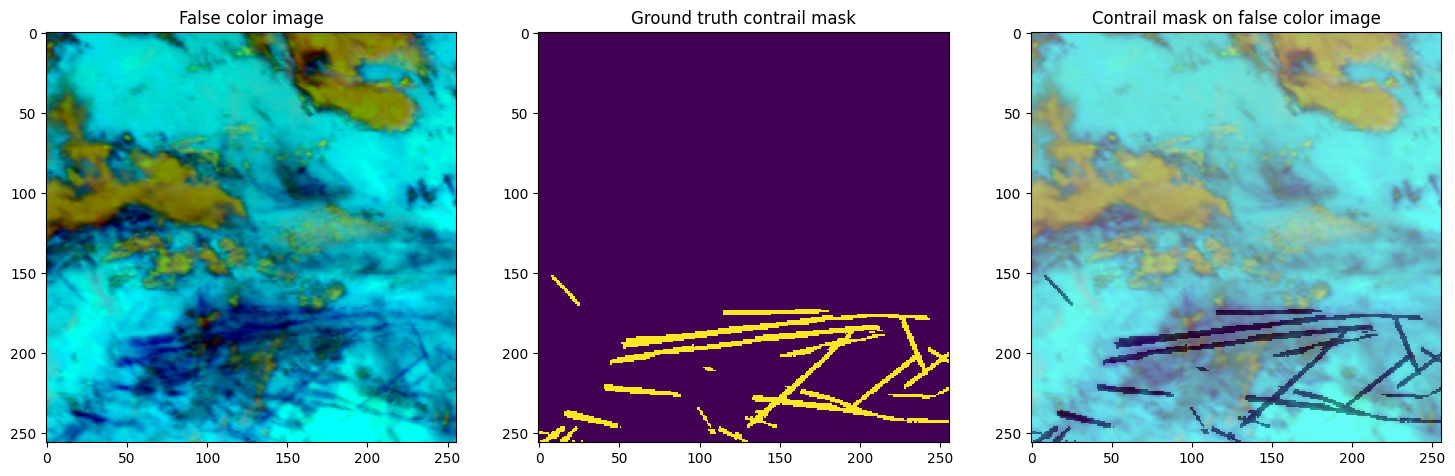

In [9]:
# Plot image
img = false_color[..., N_TIMES_BEFORE]

plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image')

ax = plt.subplot(1, 3, 2)
ax.imshow(human_pixel_mask, interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1, 3, 3)
ax.imshow(img)
ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
ax.set_title('Contrail mask on false color image');

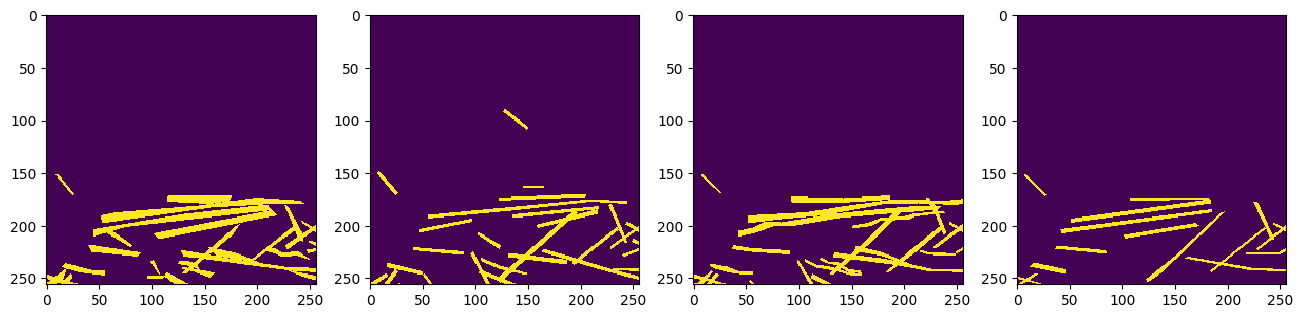

In [10]:
# Plot Individual human masks
n = human_individual_mask.shape[-1]
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(human_individual_mask[..., i], interpolation='none')

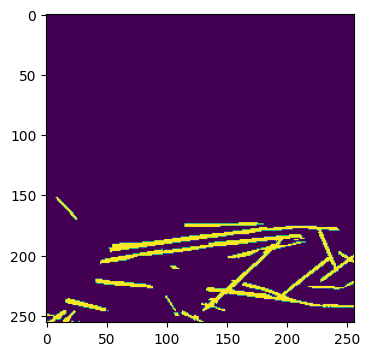

In [11]:
# Plot Individual human masks
n = human_pixel_mask.shape[-1]
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(human_pixel_mask)
    
    

In [12]:
# Animation
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(false_color[..., 0])
def draw(i):
    im.set_array(false_color[..., i])
    return [im]
anim = animation.FuncAnimation(
    fig, draw, frames=false_color.shape[-1], interval=500, blit=True
)
plt.close()
display.HTML(anim.to_jshtml())

In [13]:
train_metadata_df

metadata_record_id                                     projection_wkt  \
0      3283699311323360256  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
1      8563667897034605568  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
2      6375533009500587008  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
3      3029407526724838912  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
4      4486503791474809856  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
...                    ...                                                ...   
20524  2784921205987946496  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20525  9072953982653736960  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20526  2998013562139868160  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20527  8070893861055857664  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20528  1609423943725151232  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   

           row_min     row_size       col_min     col_size  \
0      1686563.500 -1960.975830  371650.93750  1947.130737   
1      3182392.750 -1977.611084  360291.81250  1938.791138   
2      2702499.500 -2035.440063  830456.93750  1890.603882   
3      2689881.500 -1998.106812  565498.75000  1918.643677   
4      4179394.250 -2073.804688  736862.00000  1853.664795   
...            ...          ...           ...          ...   
20524  1191489.125 -1967.661011  584308.25000  1942.752441   
20525  3694398.500 -2033.623047  622599.50000  1889.533081   
20526  1187086.250 -1948.682129  225060.00000  1956.457520   
20527  4195883.000 -2047.418579  614459.68750  1877.985962   
20528  1685851.250 -1957.424438  323984.40625  1950.255371   

                timestamp  trim_record_id            record_id  positive  
0     2019-10-13 23:20:00    328369931132  3283699311323360256         0  
1     2019-08-21 08:40:00    856366789703  8563667897034605568         0  
2     2019-10-04 20:40:00    637553300950  6375533009500587008         0  
3     2019-10-07 00:00:00    302940752672  3029407526724838912         0  
4     2019-10-29 16:30:00    448650379147  4486503791474809856         1  
...                   ...             ...                  ...       ...  
20524 2019-10-17 17:20:00    278492120598  2784921205987946496         0  
20525 2019-10-16 00:40:00    907295398265  9072953982653736960         0  
20526 2019-10-10 19:20:00    299801356213  2998013562139868160         0  
20527 2019-12-06 12:40:00    807089386105  8070893861055857664         1  
20528 2019-10-19 05:20:00    160942394372  1609423943725151232         0  

[20529 rows x 10 columns]

In [14]:
train_metadata_df["positive"].value_counts()

0    11270
1     9259
Name: positive, dtype: int64

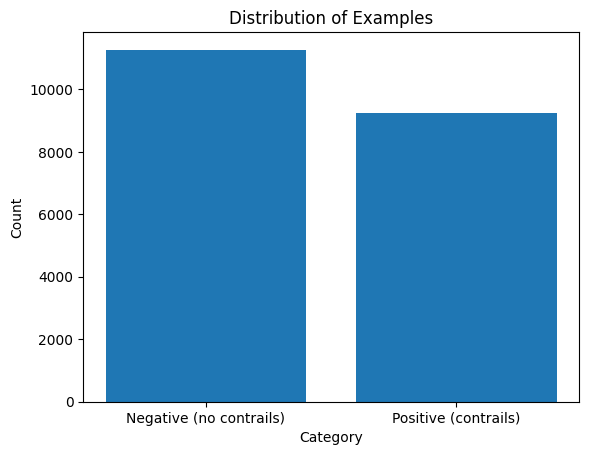

In [15]:
counts = train_metadata_df["positive"].value_counts().values
categories = ["Negative (no contrails)","Positive (contrails)"]


plt.bar(categories, counts)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Examples")
plt.show()

In [ ]:

train_metadata_df.projection_wkt.iloc[0]

'PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

##### Observing that the metadata consists of:
- record_id: 19 digit record IDs
- projection_wkt: coordinate reference system (CRS)    
    - PROJCS: the name of the CRS
    - GEOGCS: name of the geographic CRS
-  DATUM: the datum used in the geographic coordinate system. For example:
   - Name: "WGS_1984" (World Geodetic System 1984).   
   - SPHEROID: Describes the shape of the Earth.
   - Semimajor axis: 6378137 meters.
   - Inverse flattening: 298.257223563.
   - AUTHORITY: Identifies the organization that defined the parameters (EPSG code 7030).
   - AUTHORITY: Identifies the organization that defined the datum (EPSG code 6326).
   - PRIMEM: Specifies the prime meridian.
   - Name: "Greenwich".
   - Longitude: 0 degrees.
   - AUTHORITY: Identifies the organization that defined the prime meridian (EPSG code 8901).
   - UNIT: Defines the units of measurement for the CRS.
   - Name: "degree".
   - Conversion factor: 0.0174532925199433 (to convert degrees to radians).
   - AUTHORITY: Identifies the organization that defined the unit (EPSG code 9122).
   - PROJECTION: Indicates the projection method used.:
      - Name: "Transverse_Mercator" (Transverse Mercator projection).
  - PARAMETER: Specifies the projection parameters.
    - latitude_of_origin: 0 degrees.
    - central_meridian: -51 degrees.
    - scale_factor: 0.9996.
    - false_easting: 500000 meters.
    - false_northing: 0 meters.
   - UNIT: Defines the units of measurement for the CRS.
      - Name: "metre".
      - Conversion factor: 1 (meter is the base unit).
      - AUTHORITY: Identifies the organization that defined the unit (EPSG code 9001).
      - AXIS: Defines the orientation of the coordinate axes.
      - Name: "Easting" (horizontal axis).
      - Direction: EAST.
      - AXIS: "Northing" (vertical axis)
      - Direction: NORTH

In [ ]:
print(f'trains:\t{len(train_paths)}')

trains:	47


In [ ]:
val_paths = 'kaggle-contrails/contrails-kaggle-files/validation/*'

In [ ]:
print(f'vals:\t{len(val_paths)}')

vals:	52


In [17]:
len(train_metadata_df)

20529